In [1]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from plot_utils import process_flower_logs, read_fedless_logs

### How to use

Download the latest zip file with all experiment artifacts from `https://fedless-experiment-artifacts.s3.eu-central-1.amazonaws.com/fedless-experiments-1096e15-1628246697.zip`, unzip it, and copy the absolute path to the `out` folder.

### Global Variables and Style Configuration

In [127]:
ROOT_OUT_DIR = Path("/Users/andreas/workspace/thesis-code/out/")
PLOT_OUTPUT_DIR = ROOT_OUT_DIR / "plots"
FLOWER_LOGS_DIR = ROOT_OUT_DIR / "flower-logs"

PLOT_OUTPUT_DIR.mkdir(exist_ok=True)

In [128]:
plt.style.use(['science','high-contrast', 'ieee'])

In [121]:
flower_df = process_flower_logs(FLOWER_LOGS_DIR)
fedkeeper_df, fedkeeper_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedkeeper*-*-*-*-*-*-*")
fedless_df, fedless_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-[!d]*-*-*-*-*-*", ignore_dp=True) # [!d] ignores DP experiments
fedless_dp_df, fedless_dp_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-dp-*", ignore_dp=False)

## MNIST

In [122]:
df_ = fedless_df.loc[("mnist", slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[("mnist", slice(1, 200), 200), :]
df_ = df_[df_["accuracy"] >= 0.99]
df_ = df_.groupby(["clients-round", "seed"]).min("round").groupby("clients-round").mean()
df_
#sns.lineplot(x="round", y="accuracy", data=df_, hue="clients_in_round")

,round,time-aggregation,time,time-clients,clients,accuracy,loss
clients-round,,,,,,,
25,76.000000,6.582382,21.323905,14.741226,25.0,0.990200,0.035045
100,84.333333,9.083758,19.840954,10.757056,100.0,0.990033,0.039715
200,78.000000,11.297030,23.781940,12.484561,200.0,0.990133,0.039448


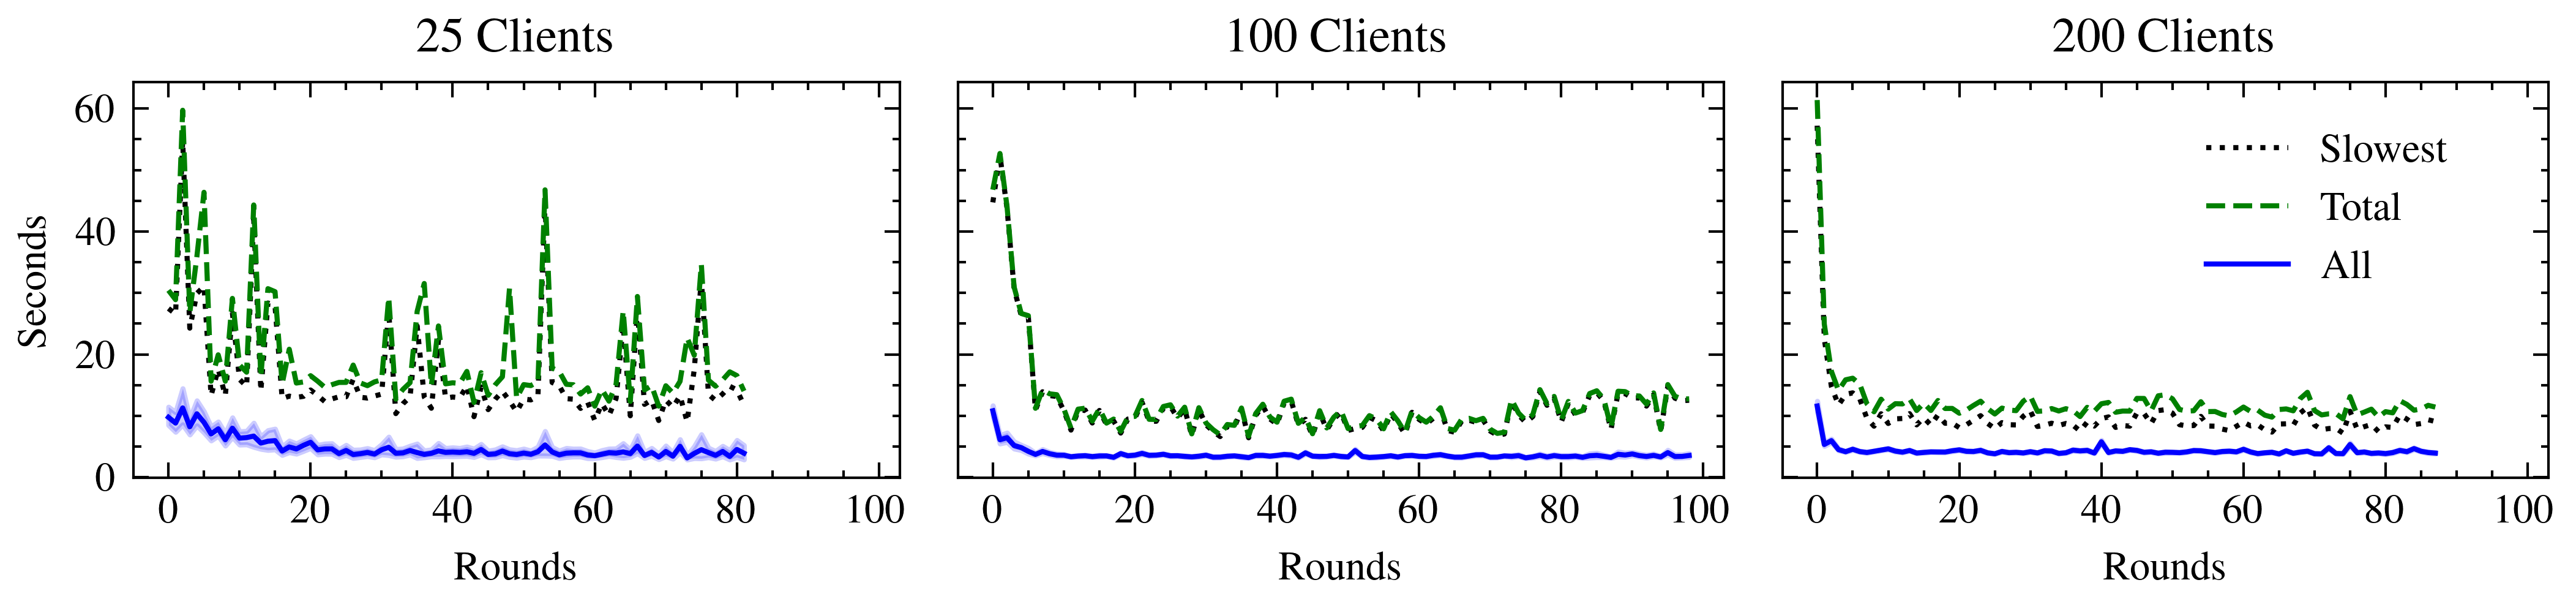

In [129]:
df_ = fedless_df.loc[("mnist", slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[("mnist", slice(1, 200), 200), :]#.reset_index()

fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))


mean_maximum_client_per_round_df = clients_df_.groupby(["clients-round", "seed", "round"]).max("seconds").groupby(["clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()
for i, clients in enumerate([25, 100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[clients],
        ax=axarr[i],
        label="Slowest"
    )
    sns.lineplot(
        x="round",
        y="time-clients",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Total"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_df_.loc[("mnist", clients)],
        ax=axarr[i],
        label="All",
        ci=95
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.5))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / "fedless-mnist-straggler-impact.pdf", bbox_inches='tight',pad_inches=0)

<ipython-input-39-5faf294476b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]


<AxesSubplot:ylabel='seconds'>

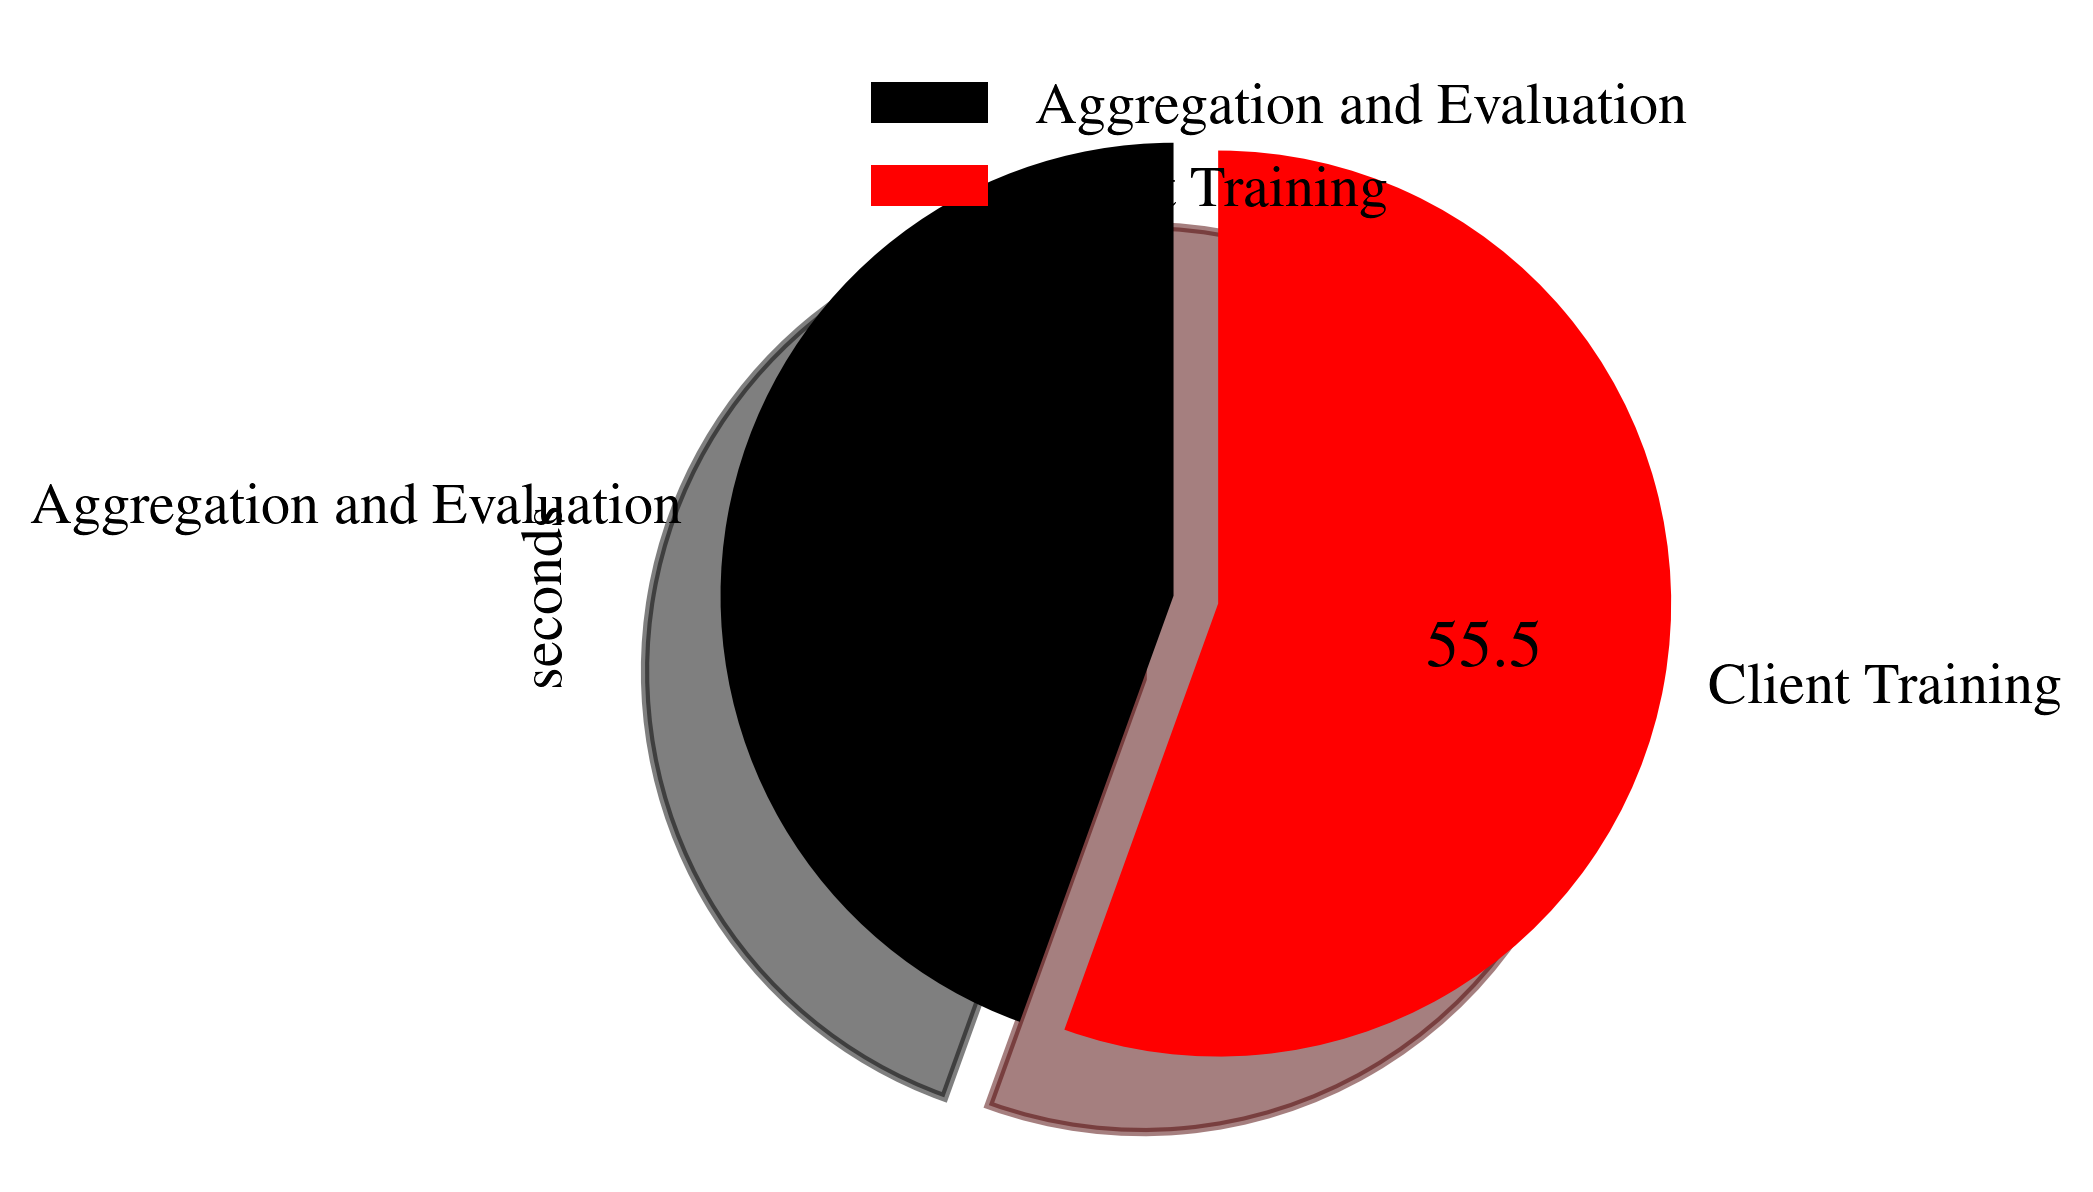

In [39]:
df_ = fedless_df.loc[("mnist", slice(100, 100)), :]
df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]
df_warm_ = df_[df_["round"] > 0]

vals = []
cols = ["aggregator_seconds", "time_clients_fit"]#, "time_remaininig"]
for col in cols:
    vals.append((col, df_warm_[col].mean()))

timing_df_ = pd.DataFrame(vals, columns=["type", "seconds"])
 # , "Rest"
timing_df_.plot.pie(y="seconds", labels=["Aggregation and Evaluation", "Client Training"], autopct='%1.1f%%', shadow=True, startangle=90, explode=[0.0, 0.1],
                   x="clients_in_round")
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

<AxesSubplot:xlabel='state', ylabel='seconds'>

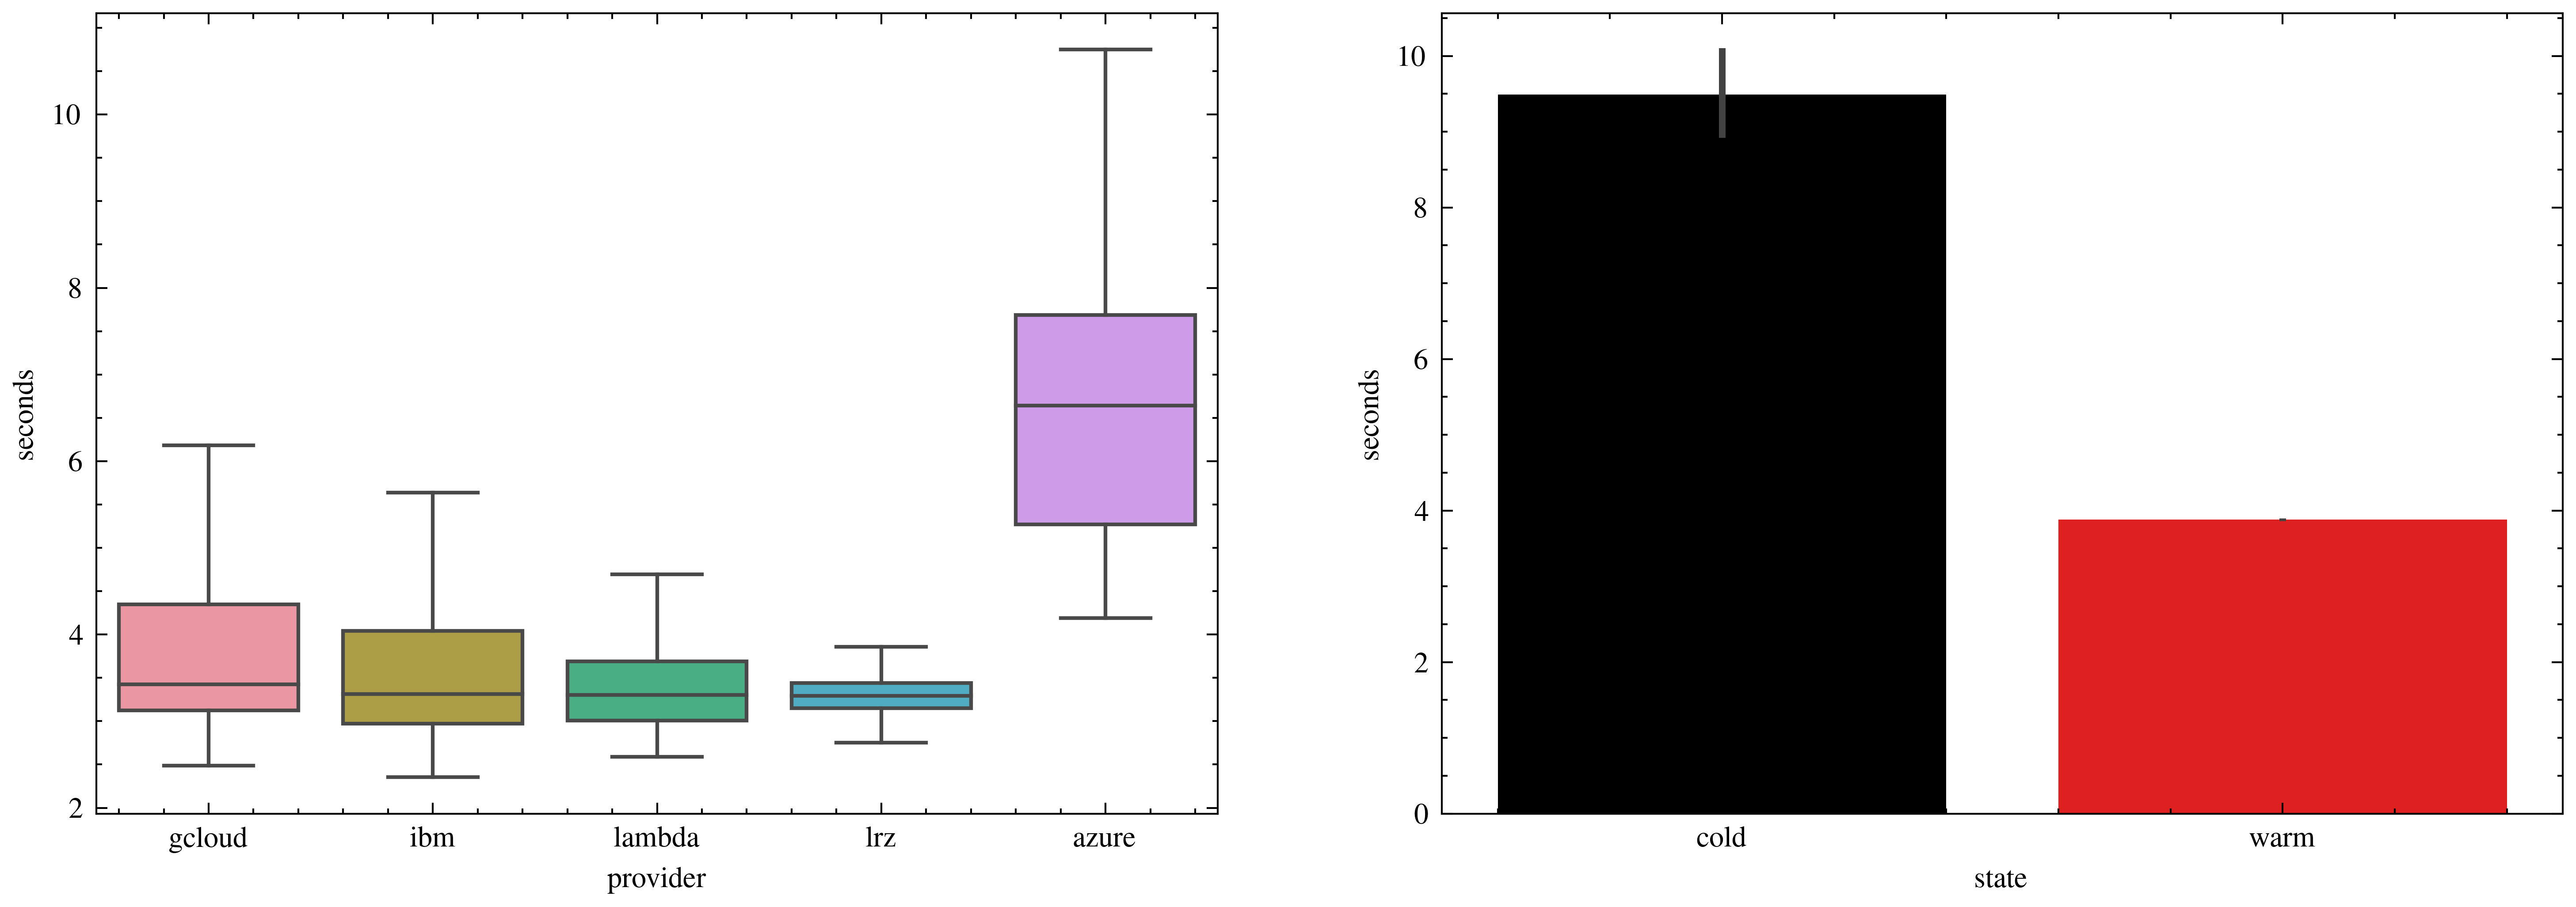

In [13]:
df_ = fedless_client_df.loc[("mnist", 100)]
df_ = df_[df_["eval"] == False]
df_["state"] = df_["round"].map(lambda r: "cold" if (r < 1) else "warm")
df_["fun_obj"] = df_["function"].map(lambda x: json.loads(x))
df_["provider"] = df_["fun_obj"].map(lambda x: x["type"] if x["type"] != "openwhisk-web" else ("ibm" if "ibm" in x["params"]["endpoint"] else "lrz"))


fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
sns.boxplot(x="provider", y="seconds", data=df_, showfliers=False, ax=axarr[0])
sns.barplot(x="state", y="seconds", data=df_, ax=axarr[1]) # showfliers=False

In [117]:
provider_runtimes = df_.groupby("provider").median("seconds")
print(provider_runtimes)

df_.groupby(["provider", "seed"]).size().groupby("provider").mean()

           seconds  round
provider                 
azure     6.642638     42
gcloud    3.423970     31
ibm       3.314852     43
lambda    3.301694     42
lrz       3.290086     42


provider
azure      206.333333
gcloud    5635.400000
ibm        422.666667
lambda     430.000000
lrz        213.000000
dtype: float64

<AxesSubplot:>

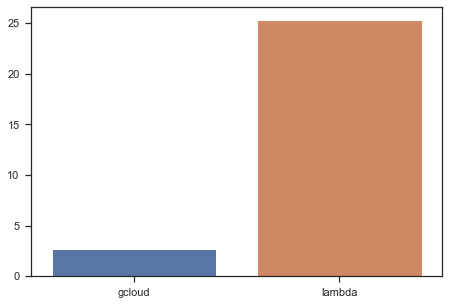

In [119]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost, calc_lambda_function_cost
from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.serialization import NpzWeightsSerializer


model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
gcloud_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=7259,
                        function_runtime_seconds=3.281925,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
lambda_cost = calc_lambda_function_cost(
    memory=2048,
    invocations=7259.000000,
    function_runtime_seconds=3.301694,
    function_egress_mb=model_size,
    num_active_instances=170,
    substract_free_tier=False)

sns.barplot(x=["gcloud", "lambda"], y=[gcloud_cost, lambda_cost])

## FEMNIST

#### Accuracy over Rounds

<AxesSubplot:xlabel='round', ylabel='accuracy'>

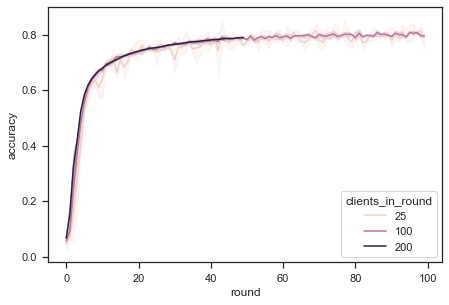

In [120]:
df_ = fedless_df.loc[("femnist", slice(1, 200)),:]

sns.lineplot(x="round", y="accuracy", data=df_, hue="clients_in_round")

<AxesSubplot:xlabel='round', ylabel='time_clients_fit'>

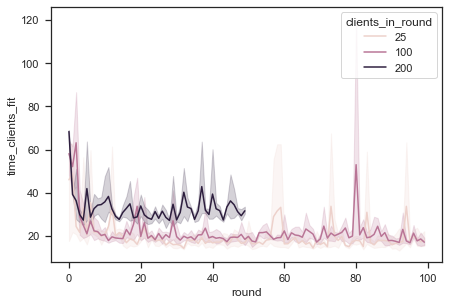

In [121]:
df_ = fedless_df.loc[("femnist", slice(1, 200)),:]

sns.lineplot(x="round", y="time_clients_fit", data=df_, hue="clients_in_round")

In [134]:
df_ = fedless_df.loc[("femnist", slice(1, 200)), :]
df_ = df_[df_["accuracy"] >= 0.791]
#sns.lineplot(x="round", y="accuracy", data=df_, hue="clients_in_round")
df_.groupby(["clients_in_round", "seed"]).min("round").groupby("clients_in_round").mean()

,round,aggregator_seconds,time,time_clients_fit,num_clients_round,accuracy,loss
clients_in_round,,,,,,,
25,28.333333,5.208004,23.719066,14.165005,25.0,0.791993,0.607490
100,42.200000,18.357640,39.254809,16.614097,100.0,0.793540,0.779705
200,47.000000,35.530464,77.176829,30.218273,200.0,0.791620,0.883602


<ipython-input-135-eec5a33bfb23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]


aggregator_seconds  \
clients_total local_epochs batch_size lr seed                                                       
200           5            10         1  3e3b524c-2999-46c4-b219-9d596031b16b           17.661931   
                                         3e3b524c-2999-46c4-b219-9d596031b16b           18.304828   
                                         3e3b524c-2999-46c4-b219-9d596031b16b           18.181643   
                                         3e3b524c-2999-46c4-b219-9d596031b16b           18.080756   
                                         3e3b524c-2999-46c4-b219-9d596031b16b           17.666283   
...                                                                                           ...   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd           19.372980   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd           18.486788   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd           17.929237   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd           20.845328   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd           18.484846   

                                                                               time_clients_fit  \
clients_total local_epochs batch_size lr seed                                                     
200           5            10         1  3e3b524c-2999-46c4-b219-9d596031b16b         58.186553   
                                         3e3b524c-2999-46c4-b219-9d596031b16b         55.327048   
                                         3e3b524c-2999-46c4-b219-9d596031b16b         36.417253   
                                         3e3b524c-2999-46c4-b219-9d596031b16b         22.934829   
                                         3e3b524c-2999-46c4-b219-9d596031b16b         21.164163   
...                                                                                         ...   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         17.947673   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         19.045947   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         15.880306   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         15.356889   
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         16.367663   

                                                                               time_remaininig  
clients_total local_epochs batch_size lr seed                                                   
200           5            10         1  3e3b524c-2999-46c4-b219-9d596031b16b        11.328665  
                                         3e3b524c-2999-46c4-b219-9d596031b16b        30.741751  
                                         3e3b524c-2999-46c4-b219-9d596031b16b        10.783612  
                                         3e3b524c-2999-46c4-b219-9d596031b16b        10.523442  
                                         3e3b524c-2999-46c4-b219-9d596031b16b         9.530980  
...                                                                                        ...  
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         4.885038  
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         3.230390  
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         2.556807  
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd        12.754834  
                                         f4b18da8-9bb8-493d-bbe1-6f8a06e1ddfd         3.328625  

[471 rows x 3 columns]

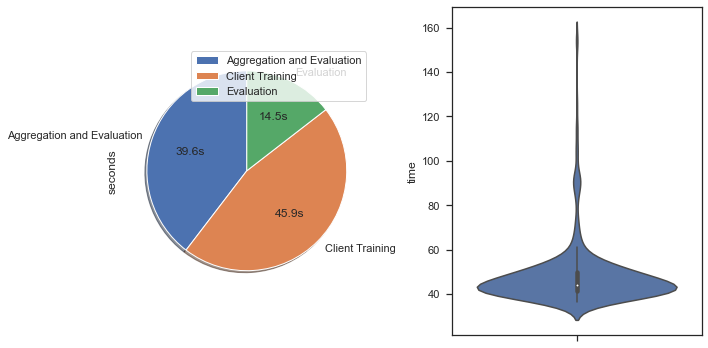

In [135]:
df_ = fedless_df.loc[("femnist", 100)]
df_["time_remaininig"] = df_["time"] - df_["time_clients_fit"] - df_["aggregator_seconds"]
df_warm_ = df_[df_["round"] > 0]

vals = []
cols = ["aggregator_seconds", "time_clients_fit", "time_remaininig"]
for col in cols:
    vals.append((col, df_warm_[col].mean()))

timing_df_ = pd.DataFrame(vals, columns=["type", "seconds"])

fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))

timing_df_.plot.pie(y="seconds", labels=["Aggregation and Evaluation", "Client Training", "Evaluation"], autopct='%.1fs', 
                    shadow=True, startangle=90, explode=[0.0, 0.0, 0.0], ax=axarr[0],
                    normalize=True)
sns.violinplot(y="time", ax=axarr[1], data=df_warm_)
#sns.boxplot(y="time", ax=axarr[1], data=df_warm_, showcaps=False,widths=0.06, patch_artist=True)
df_warm_[["aggregator_seconds", "time_clients_fit", "time_remaininig"]]
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

<AxesSubplot:xlabel='state', ylabel='seconds'>

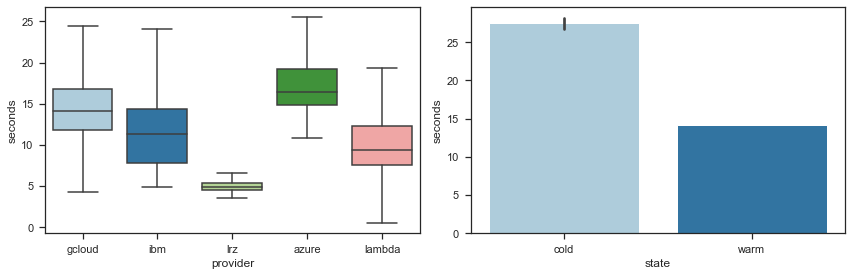

In [136]:
df_ = fedless_client_df.loc[("femnist", 100)]
df_ = df_[df_["eval"] == False]

fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
sns.boxplot(x="provider", y="seconds", data=df_, showfliers=False, palette=SNS_DEFAULT_PALETTE, ax=axarr[0])
sns.barplot(x="state", y="seconds", data=df_, palette=SNS_DEFAULT_PALETTE, ax=axarr[1]) # showfliers=False

In [137]:
df_ = fedless_client_df.loc[("femnist", 100)]
df_ = df_[df_["eval"] == False]
provider_runtimes = df_.groupby("provider").median("seconds")
print(provider_runtimes)

df_.groupby(["provider", "seed"]).size().groupby("provider").mean()

            seconds  round
provider                  
azure     16.391720     36
gcloud    14.084828     36
ibm       11.285376     36
lambda     9.410488     37
lrz        4.837240     34


provider
azure      171.714286
gcloud    5794.428571
ibm        342.285714
lambda     341.000000
lrz        156.142857
dtype: float64

In [138]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost
from fedless.benchmark.leaf import create_femnist_cnn, create_shakespeare_lstm
from fedless.serialization import NpzWeightsSerializer

#model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_shakespeare_lstm().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=1000,
                        function_runtime_seconds=300,
                        function_egress_mb=model_size,
                        substract_free_tier=False)

9.0842876171875

In [139]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost
from fedless.benchmark.leaf import create_femnist_cnn, create_shakespeare_lstm
from fedless.serialization import NpzWeightsSerializer

#model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_shakespeare_lstm().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=2500,
                        function_runtime_seconds=200,
                        function_egress_mb=model_size,
                        substract_free_tier=False)

15.460719042968751

,round,aggregator_seconds,time,time_clients_fit,num_clients_round,accuracy,loss
clients_in_round,,,,,,,
10,0,0.685110,72.136217,51.721851,10,0.186837,1.505720
25,0,1.220946,124.790796,97.930011,25,0.185645,1.467083


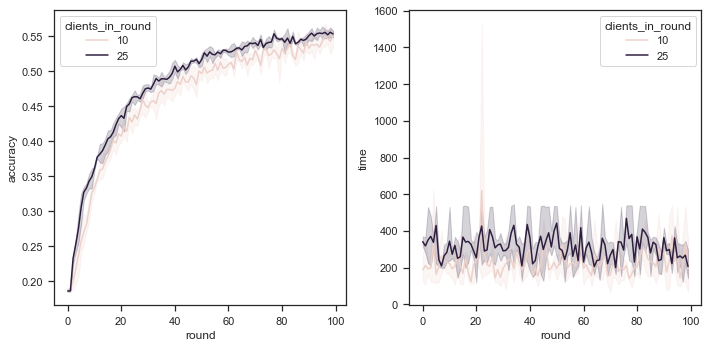

In [140]:
df_ = fedless_df.loc[("shakespeare", slice(1, 200)), :]

fig, axarr = plt.subplots(ncols=2, figsize=(10, 5))
#df_ = df_[df_["accuracy"] >= 0.5]
sns.lineplot(x="round", y="accuracy", data=df_, hue="clients_in_round", ax=axarr[0])
sns.lineplot(x="round", y="time", data=df_, hue="clients_in_round", ax=axarr[1])
df_.groupby(["clients_in_round", "seed"]).min("round").groupby("clients_in_round").mean()

## MNIST with Privacy

['Unnamed: 0', 'round_id', 'aggregator_seconds', 'round_seconds', 'clients_finished_seconds', 'num_clients_round', 'global_test_accuracy', 'global_test_loss']


Text(0, 0.5, 'Round Duration (sec)')

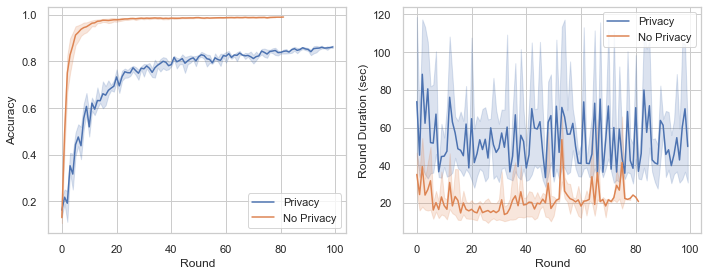

In [142]:
sns.set_style("whitegrid")
#ns.set(#font="Helvetica", #"Franklin Gothic Book",
#        rc={
# "axes.edgecolor": "lightgrey",
# "axes.facecolor": "None",
# "axes.grid": True,
# #‘axes.labelcolor’: ‘dimgrey’,
# "axes.spines.right": False,
# "axes.spines.top": False,
#"figure.autolayout": True,
# #‘figure.facecolor’: ‘white’,
# #‘lines.solid_capstyle’: ‘round’,
# #‘patch.edgecolor’: ‘w’,
# #‘patch.force_edgecolor’: True,
# #‘text.color’: ‘dimgrey’,
# #‘xtick.bottom’: False,
# #‘xtick.color’: ‘dimgrey’,
# #‘xtick.direction’: ‘out’,
# #‘xtick.top’: False,
# #‘ytick.color’: ‘dimgrey’,
# #‘ytick.direction’: ‘out’,
# #‘ytick.left’: False,
# #‘ytick.right’: False})
#        })


fig, axarr = plt.subplots(ncols=2, figsize=(10, 4))
sns.lineplot(x="round_id", y="global_test_accuracy", data=priv_timing_df, ax=axarr[0], label="Privacy")
sns.lineplot(x="round", y="accuracy", data=fedless_df.loc[("mnist", 25), :], ax=axarr[0], label="No Privacy")

sns.lineplot(x="round_id", y="round_seconds", data=priv_timing_df, ax=axarr[1], label="Privacy")
sns.lineplot(x="round", y="time", data=fedless_df.loc[("mnist", 25), :], ax=axarr[1], label="No Privacy")

axarr[0].set_xlabel("Round")
axarr[1].set_xlabel("Round")

axarr[0].set_ylabel("Accuracy")
axarr[1].set_ylabel("Round Duration (sec)")

## FedKeeper vs FedLess

GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters
FedLess: 4.5466+-1.24303939025048ms
FedKeeper (Optimized): 3.914878787878788+-0.27050925683771787ms
FedKeeper (Vanilla): 5.6882666666666655+-2.769687141577948ms


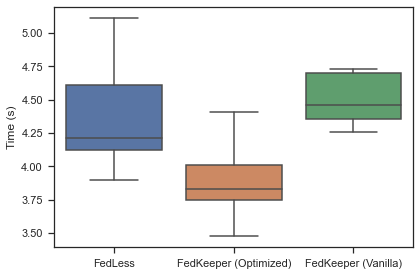

In [112]:
fedkeeper_gcloud_client_1_log_df = pd.read_csv("/Users/andreas/workspace/thesis-code/out/fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181515-http-1.csv")
fedless_gcloud_client_1_log_df = pd.read_csv("/Users/andreas/workspace/thesis-code/out/fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181149-client-indep-1.csv")
fedkeeper_uncached_gcloud_clientlog_df = pd.read_csv("/Users/andreas/workspace/thesis-code/out/fedkeeper-fedless-gcloud-logs/downloaded-logs-20210806-152324-client-no-caching.csv")


print(f"GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters")
vals = []
for method, df in [("FedLess", fedless_gcloud_client_1_log_df), ("FedKeeper (Optimized)", fedkeeper_gcloud_client_1_log_df), ("FedKeeper (Vanilla)", fedkeeper_uncached_gcloud_clientlog_df)]:
    log_statements  = df[df['textPayload'].astype(str).str.contains("Function execution took ")].textPayload
    timings = np.array([float(line[len("Function execution took "):].split(' ')[0]) for line in log_statements]) / 1000
    vals.append((method, timings))
    print(f"{method}: {timings.mean()}+-{timings.std()}ms")

df = pd.concat([pd.Series(timings) for _, timings in vals], keys=[m for m, _ in vals], names=["method"]).to_frame().reset_index()
sns.set_theme(style="ticks")
#plt.style.use("seaborn-paper")
#sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x="method", y=0, data=df, ax=ax, showfliers=False) # showfliers=False => WARM STARTS ONLY
ax.set_xlabel("")
ax.set_ylabel("Time (s)")
fig.tight_layout()

fedkeeper_optimization_mean_difference = (df[df["method"] == "fedkeeper (vanilla)"].mean() - df[df["method"] == "fedkeeper (optimized)"].mean())[0]

<AxesSubplot:xlabel='round', ylabel='accuracy'>

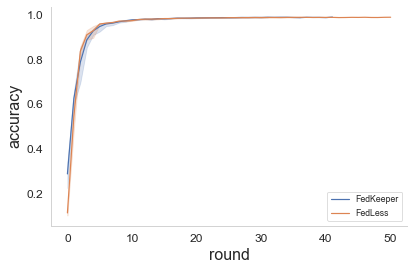

In [5]:
fedless_df_ = fedless_df.loc[("mnist", slice(1, 100), 100),:] # FedKeeper experiments
fedless_client_df_ = fedless_client_df.loc[("mnist", slice(1, 100), 100),:] # FedKeeper experiments


sns.lineplot(y="accuracy", x="round", data=fedkeeper_df.loc[("mnist", 25, 100),:], label="FedKeeper", )#, color="red")
sns.lineplot(y="accuracy", x="round", data=fedless_df_.loc[("mnist", 25, 100),:], label="FedLess", )# , color="blue")

In [33]:
fedkeeper_unoptimized = fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index().copy()
fedkeeper_unoptimized["time"] += fedkeeper_optimization_mean_difference
fl_fk_comp_df = pd.concat([
    fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index(),
#    fedkeeper_unoptimized,
    fedless_df_.loc[("mnist", slice(1, 75), 100),:].reset_index()
], keys=["FedKeeper", "FedLess"], names=["method"]).reset_index()
#], keys=["FedKeeper (optimized)", "FedKeeper (vanilla)", "FedLess"], names=["method"]).reset_index()
fl_fk_comp_df['cumsum'] = fl_fk_comp_df.groupby(["method", "clients_in_round", "seed"])['time'].transform(pd.Series.cumsum)

time                      
                                 mean     median        std
method    clients_in_round                                 
FedKeeper 25                18.383194  12.048295   9.612048
          50                17.857385  13.123293  11.560761
          75                18.962259  15.309069  12.238020
FedLess   25                12.341028   9.753099   4.578256
          50                12.832891  10.884840   4.215781
          75                13.999582  12.297168   3.867614

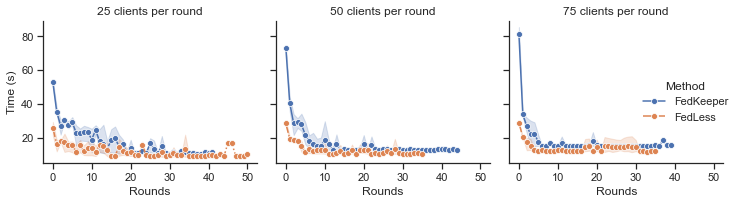

In [46]:
sns.set_theme(style="ticks")
#sns.set_style("whitegrid")
grid = sns.FacetGrid(fl_fk_comp_df, col="clients_in_round",hue="method", hue_kws={"ls" : ["-","-.",":"]})
grid.map(sns.lineplot, "round", "time", marker="o")
grid.set_axis_labels("Rounds", "Time (s)")
grid.set_titles(col_template="{col_name} clients per round")# , row_template="{row_name}")
grid.add_legend()
grid.fig.tight_layout()
grid._legend.set_title("Method")
filename = "fedkeeper-fedless-timings.pdf"
os.remove(filename) if os.path.exists(filename) else None
grid.savefig(filename)#, overwrite=True)
fl_fk_comp_df.groupby(["method", "clients_in_round"]).agg({'time': [np.mean, np.median, np.std]})

In [99]:
def mean_std(vals):
    return f"{np.mean(vals).round(1)}$\pm${np.std(vals).round(1)}"
df_ = fl_fk_comp_df.groupby(["method", "clients_in_round"]).agg({'time': [mean_std]})#[np.mean, np.median, np.std]}).T.round(1)
df_.columns = ["time"]
#print(df_.to_latex())
print(df_.reset_index().pivot(index="clients_in_round", columns="method").to_latex())

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{time} \\
method &      FedKeeper &       FedLess \\
clients\_in\_round &                &               \\
\midrule
25               &   18.4\$\textbackslash pm\$9.6 &  12.3\$\textbackslash pm\$4.6 \\
50               &  17.9\$\textbackslash pm\$11.5 &  12.8\$\textbackslash pm\$4.2 \\
75               &  19.0\$\textbackslash pm\$12.2 &  14.0\$\textbackslash pm\$3.8 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='round', ylabel='accuracy'>

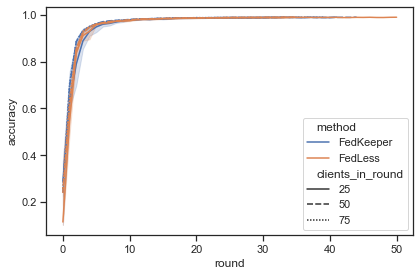

In [140]:
df_ = fl_fk_comp_df
sns.lineplot(x="round", y="accuracy", data=df_, hue="method", style="clients_in_round")
#df_.groupby(["method", "clients_in_round", "seed"]).min("round").groupby(["method", "clients_in_round"]).mean()["round"]

GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters
fedless: 4.5466+-1.24303939025048ms
fedkeeper (optimized): 3.914878787878788+-0.27050925683771787ms
fedkeeper (vanilla): 5.6882666666666655+-2.769687141577948ms


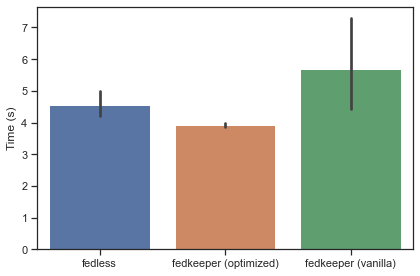